In [7]:
# For folder processing
from scipy.io import loadmat
import os
import tarfile
import shutil
from tqdm import tqdm
import requests

# For Image Processing and Display
import cv2 as cv
from matplotlib import pyplot as plt
%matplotlib inline 

# For Visualization
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = True)

# For data processing
from collections import defaultdict
import numpy as np
import pandas as pd

# For machine learning
from sklearn.model_selection import train_test_split


# For Training Image Classification Model
from keras.models import load_model, Sequential
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from sklearn.preprocessing import LabelBinarizer
from keras.utils import to_categorical
from keras import optimizers
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

In [8]:
!pwd

/home/meraldoantonio/Desktop/Car-classifier


# Preprocessing
## Downloading the Datasets and Their Labels

In [65]:
def download_file(target_url, target_folder):
    """
    Function:
        - Creates a relative path `target_folder` in the current working directory if it doesn't exist yet
        - Downloads a file from `target_url` and puts it into the `target_folder`
        
    Arguments:
        - target_url (str): source URL of the file to be downloaded
        - target_folder (str): relative path of the folder into which the file is to be downloaded
    """
    
    file_name = target_url.split("/")[-1]
    target_file_path = os.path.join(target_folder,file_name)
    
    # If the file has already been downloaded in the correct directory, exit function
    if os.path.exists(target_file_path):
        print(f"The file '{file_name}' has already been downloaded into '{target_folder}'")
        return
    
    # If the target_folder doesn't exist yet, create it
    if not os.path.exists(target_folder):
        os.mkdir(target_folder)
        print(f"Created a new folder at '{target_folder}'")
        
    # Download the file into the target_folder
    print(f"Downloading '{file_name}' from '{target_url}', please wait...")
    chunk_size = 1024
    r = requests.get(target_url, stream = True)
    size = int(r.headers['content-length'])
    print(f"File size = {size/chunk_size} KB.")    
    with open(target_file_path, 'wb') as f:
        for data in tqdm(iterable = r.iter_content(chunk_size = chunk_size),total = size/chunk_size, unit = 'KB'):
            f.write(data)
    
    
    print(f"The file '{file_name}' has been downloaded into '{target_folder}'")
    return

In [66]:
train_url = "http://imagenet.stanford.edu/internal/car196/cars_train.tgz"
devkit_url = "https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz"
target_folder = "./tgz"

In [67]:
download_file(train_url, target_folder)

The file 'cars_train.tgz' has already been downloaded into './tgz'


In [68]:
download_file(devkit_url, target_folder)

The file 'car_devkit.tgz' has already been downloaded into './tgz'


## Unzipping the Datasets

In [69]:
def extract_dataset(source_file_path, target_folder):
    """
    Function:
        - Unzips the tar file in `source_file_path` into `target_folder`
        
    Arguments:
        - source_file_path (str): relative path of target file
        - target_folder (str): relative path of target folder
    """
    
    tar = tarfile.open(source_file_path)
    tar.extractall(target_folder)
    tar.close()
    file_list = [f for f in os.listdir(target_folder)]
    print(f"Extraction complete!")
    print(f"{len(file_list)} files/subfolders have been added into your target folder `{target_folder}`")

In [70]:
extract_dataset("./tgz/cars_train.tgz", "./data")

Extraction complete!
1 files/subfolders have been added into your target folder `./data`


In [71]:
extract_dataset("./tgz/car_devkit.tgz", "./metadata")

Extraction complete!
1 files/subfolders have been added into your target folder `./metadata`


# Preprocessing
## Get the Class Names

In [72]:
def create_metadata_dataframe():
    """
    Function:
        - Creates a combined metadata dataframe from the two zipped metadata files provided
    Returns:
        - df (pandas dataframe): a dataframe containing the metadata of files in the training set
    """
    
    # Load the matlab file that contains the complete list of class names
    original_dict_metadata = loadmat('./metadata/devkit/cars_meta.mat')
    
    # Create a dictionary `dict_classnumber_classname` that maps the class numbers to class names
    dict_classnumber_classname = {int(index+1):classname[0] for index, classname in enumerate(original_dict_metadata["class_names"][0])}
    
    # Load the matlab file that contains the metadata (bounding box details and class details) for each training sample
    original_dict_traindata = loadmat('./metadata/devkit/cars_train_annos.mat')
    
    # Create an empty dictionary `dict_filename_metadata` that maps the file names and metadata 
    dict_filename_metadata = {}

    # Populate `dict_filename_metadata` by looping through `original_dict_traindata`
    dict_filename_metadata = {image[5][0]:{"bbox_xmin": image[0][0][0], "bbox_ymin": image[1][0][0],"bbox_xmax": image[2][0][0],"bbox_ymax": image[3][0][0],"classnumber": image[4][0][0], "classname": dict_classnumber_classname[image[4][0][0]]} for image in original_dict_traindata["annotations"][0]}
    
    # Converts `dict_filename_metadata` into a dataframe
    df = pd.DataFrame.from_dict(data = dict_filename_metadata, orient = "index")
    
    return df

In [73]:
df = create_metadata_dataframe()

In [74]:
df.shape

(8144, 6)

In [75]:
counts = df.groupby('classname')['classnumber'].count()
trace = go.Bar(x = counts.index, y = counts.values)
data = [trace]
layout = go.Layout(title = "Number of Samples per Class",
                  xaxis = {
                            'categoryorder': 'array',
                            'categoryarray': [x for _, x in sorted(zip(counts.values,counts.index))],
                            'showticklabels': False})
                           
figure = go.Figure(data = data, layout = layout)
iplot(figure)

In [76]:
# some quick visualization of the data (number of classes)
# Preprocess first

In [86]:

def show_image_from_folder(images_source_path = "./data/cars_train", index = 0):
    
    image_list = os.listdir(images_source_path)
    filename = image_list[index]
    print(f"Index: {index}")
    print(f"Filename: {filename}")
    classname = df.loc[filename,["classname"]].values[0]
    print(f"Car class: {classname}")
    
    img = cv.imread(os.path.join(images_source_path,filename)) # do this for others too
    bgr_img = np.array(img)
    print(f"Original height:{bgr_img.shape[0]}, original width:{bgr_img.shape[1]}")
    xmin,ymin,xmax,ymax = df.loc[filename,["bbox_xmin","bbox_ymin","bbox_xmax","bbox_ymax"]].values
    print(f"Bounding box position - xmin: {xmin},ymin: {ymin},xmax: {xmax},ymax: {ymax}")
    
    # The preprocessing steps
    rgb_img = cv.cvtColor(bgr_img, cv.COLOR_BGR2RGB) # Change BGR to RGB
    cropped_img = rgb_img[ymin:ymax, xmin:xmax] # Cropping
    resized_img = cv.resize(cropped_img, (224, 224)) # Resizing
    print(resized_img.max())
    print(resized_img.min())
    
    preprocessed_img = preprocess_input(resized_img) # Resnet preprocessing
    print(preprocessed_img.max())
    print(preprocessed_img.min())
    # Visualize the original image as well as the three preprocessed images
    fig, [[ax1, ax2,], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
    ax1.imshow(rgb_img, interpolation='nearest')
    ax1.set_title("1. Original Image")
    ax2.imshow(cropped_img, interpolation='nearest')
    ax2.set_title("2. Cropped Image")
    ax3.imshow(resized_img, interpolation='nearest')
    ax3.set_title("3. Cropped + Resized Image")  
    ax4.imshow(preprocessed_img, interpolation='nearest')
    ax4.set_title("4. Cropped + Resized + Preprocessed Image")
    plt.show()
    

In [87]:
?preprocess_input

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Index: 10
Filename: 05435.jpg
Car class: Audi TT Hatchback 2011
Original height:178, original width:283
Bounding box position - xmin: 3,ymin: 39,xmax: 281,ymax: 149
255
0
151.061
-123.68


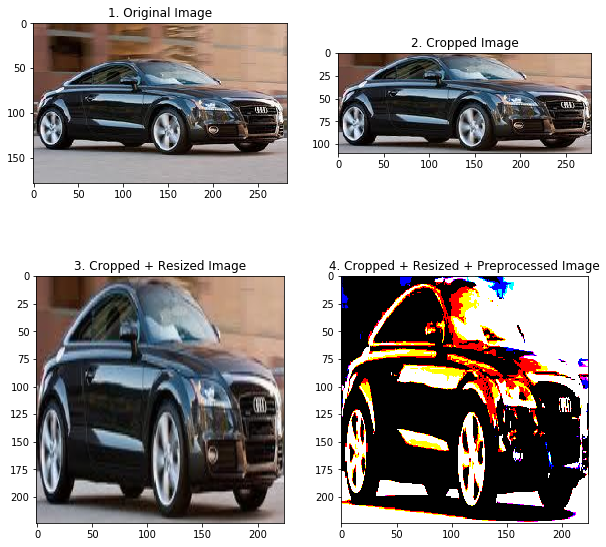

In [88]:
show_image_from_folder(index = 10)

In [ ]:

def preprocess_images(images_source_path = "./data/cars_train", images_destination_path = "./data_preprocessed", metadata = df):
    
    image_list = os.listdir(images_source_path)
    length_image_list = len(image_list)
    #print(f"There are {length_image_list} to preprocess.")
    
    for index, filename in enumerate(image_list):
        #print(f"Preprocessing {filename}, which is image {index + 1} out of {length_image_list}.")
        img = cv.imread(os.path.join(images_source_path,filename)) # do this for others too
        np_img = np.array(img)
        xmin,ymin,xmax,ymax = df.loc[filename,["bbox_xmin","bbox_ymin","bbox_xmax","bbox_ymax"]].values

        np_img = cv.cvtColor(np_img, cv.COLOR_BGR2RGB) # Change BGR to RGB
        np_img = np_img[ymin:ymax, xmin:xmax] # Cropping
        np_img = cv.resize(np_img, (224, 224)) # Resizing
        np_img = preprocess_input(np_img) # Resnet preprocessing

        cv.imwrite(os.path.join(images_destination_path,filename), np_img)

In [ ]:
#preprocess_images()

In [ ]:
def sort_images(target_path = "./data_preprocessed", metadata = df, train_size = 0.9):
    """
    Function:
        - Creates subfolders "train" and "valid" inside "target_path"
        - Inside "train" and "valid", create one subfolder for every unique class 
    Argument:
        - df (pandas dataframe): a dataframe containing the metadata of files
    """   
    
    
    df_train, df_valid = train_test_split(metadata, train_size = train_size, random_state = 88, stratify = df.classnumber)
   
    # Creation of "train" and "valid" subfolders if they don't exist yet
    folders = ["train", "valid"]
    for folder in folders:
        if not os.path.exists(os.path.join(target_path, folder)):
            os.makedirs(os.path.join(target_path, folder))
            
     # Inside "train" and "valid", create one subfolder for every unique class            
        for classname in metadata.classname.unique():
            if not os.path.exists(os.path.join(target_path, folder, classname)):
                os.makedirs((os.path.join(target_path, folder, classname)))
    
 
        if folder == "train":
            df_focus = df_train
        else:
            df_focus = df_valid
            
        for filename in df_focus.index:
            classname = df_focus.loc[filename, "classname"]

            source_path = os.path.join(target_path, filename)
            destination_path = os.path.join(target_path, folder, classname, filename)
            shutil.move(source_path, destination_path)


In [ ]:
def load_resnet_model():
    """
    Function:
        - If the ResNet50 model isn't already saved, the function will download the model, save it to ./model/ResNet50.h5 and return it
        - If model is already saved, the function will simply return the model
    Return:
        - The original ResNet50 model
    """
    model_path = "./model/ResNet50.h5"
    if os.path.exists(model_path):
        print(f"Retrieving saved model from {model_path}...")
        model = load_model(model_path)
        print("Saved model retrieved!")
        return model
    else:
        from keras.applications.resnet50 import ResNet50
        print("Downloading model...")
        model = ResNet50(weights='imagenet')
        model.save(model_path)
        print(f"Model retrieved and saved in {model_path}")
        return model

In [ ]:
resnet50 = load_resnet_model()

# Model

In [52]:
def load_untrained_transfer_model():
    """
    If model isn't saved - download model, save it to current directory and return it
    If model already exists, simply return the model
    """
    model_path = "./model/Untrained_transfer.h5"
    if os.path.exists(model_path):
        print(f"Retrieving saved model from {model_path}")
        untrained_transfer_model = load_model(model_path)
        print("Saved model retrieved!")
        return untrained_transfer_model
    else:
        ## Build model
        print("Downloading and building model...")
        untrained_transfer_model = Sequential()
        untrained_transfer_model.add(ResNet50(include_top = False, pooling = "avg", weights = "imagenet"))
        untrained_transfer_model.add(Dense(512, activation = "relu"))
        untrained_transfer_model.add(Dropout(0.5))
        untrained_transfer_model.add(Dense(512, activation = "relu"))
        untrained_transfer_model.add(Dropout(0.5))
        untrained_transfer_model.add(Dense(512, activation = "relu"))
        untrained_transfer_model.add(Dropout(0.5))
        untrained_transfer_model.add(Dense(512, activation = "relu"))
        untrained_transfer_model.add(Dropout(0.5))
        untrained_transfer_model.add(Dense(512, activation = "relu"))
        untrained_transfer_model.add(Dropout(0.5))
        untrained_transfer_model.add(Dense(512, activation = "relu"))
        untrained_transfer_model.add(Dropout(0.5))
        untrained_transfer_model.add(Dense(196, activation = "softmax"))
        
        untrained_transfer_model.layers[0].trainable = False
        
        ## Save model
        print(f"Model built and saved in {model_path}")
        untrained_transfer_model.save(model_path)
        return untrained_transfer_model

In [53]:
transfer_model = load_untrained_transfer_model()

Model built and saved in ./model/Untrained_transfer.h5


In [54]:
transfer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
__________

In [55]:
from keras.optimizers import SGD
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
transfer_model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])

In [56]:
#df_train["preprocessed_np_image"] = df_train["np_image"].apply(lambda x: preprocess_image(x))

In [57]:
from keras.preprocessing.image import ImageDataGenerator

In [58]:

train_data = './data_preprocessed/train'
valid_data = './data_preprocessed/valid'
n_train_samples = len(os.listdir(train_data))
n_valid_samples = len(os.listdir(valid_data))
verbose = 1
batch_size = 16
n_epochs = 15000
patience = 100

In [59]:
train_ImageDataGenerator = ImageDataGenerator(rotation_range=20.,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True)


valid_ImageDataGenerator = ImageDataGenerator()

In [60]:
# generators
train_generator = train_ImageDataGenerator.flow_from_directory(train_data, (224, 224), batch_size=batch_size,
                                                     class_mode='categorical')
valid_generator = valid_ImageDataGenerator.flow_from_directory(valid_data, (224, 224), batch_size=batch_size,
                                                     class_mode='categorical')


Found 6515 images belonging to 196 classes.
Found 1629 images belonging to 196 classes.


In [61]:
# define callbacks
#tensor_board = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

log_file_path = 'logs/training.log'
csv_logger = CSVLogger(log_file_path, append=False)

early_stop = EarlyStopping('val_acc', patience=patience)

reduce_lr = ReduceLROnPlateau('val_acc', factor=0.1, patience=int(patience / 4), verbose=1)

trained_models_path = 'model/model'
model_names = trained_models_path + '.{epoch:02d}-{val_acc:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, monitor='val_acc', verbose=1, save_best_only=True)


callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]



In [62]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [63]:
config

# What made it work? We' ll never know
# But it may be this: pip install update tensorflow-gpu==1.13.1


gpu_options {
  allow_growth: true
}

In [64]:
# fine tune the model
history = transfer_model.fit_generator(
    generator = train_generator,
    steps_per_epoch = n_train_samples / batch_size,
    validation_data = valid_generator,
    validation_steps = n_valid_samples / batch_size,
    epochs = n_epochs,
    callbacks = callbacks,
    verbose = 1)

Epoch 1/15000
13/12 [===============================] - 8s 588ms/step - loss: 5.6793 - acc: 0.0048 - val_loss: 5.2922 - val_acc: 0.0096

Epoch 00001: val_acc improved from -inf to 0.00962, saving model to model/model.01-0.01.hdf5
Epoch 2/15000
13/12 [===============================] - 1s 109ms/step - loss: 5.4345 - acc: 0.0048 - val_loss: 5.2801 - val_acc: 0.0048

Epoch 00002: val_acc did not improve from 0.00962
Epoch 3/15000
13/12 [===============================] - 2s 161ms/step - loss: 5.4084 - acc: 0.0048 - val_loss: 5.2803 - val_acc: 0.0000e+00

Epoch 00003: val_acc did not improve from 0.00962
Epoch 4/15000
13/12 [===============================] - 2s 185ms/step - loss: 5.4240 - acc: 0.0096 - val_loss: 5.2805 - val_acc: 0.0096

Epoch 00004: val_acc did not improve from 0.00962
Epoch 5/15000
13/12 [===============================] - 2s 185ms/step - loss: 5.3022 - acc: 0.0048 - val_loss: 5.2776 - val_acc: 0.0096

Epoch 00005: val_acc did not improve from 0.00962
Epoch 6/15000
13/1

Epoch 43/15000
13/12 [===============================] - 3s 195ms/step - loss: 5.3015 - acc: 0.0096 - val_loss: 5.2803 - val_acc: 0.0192

Epoch 00043: val_acc did not improve from 0.02885
Epoch 44/15000
13/12 [===============================] - 3s 212ms/step - loss: 5.3000 - acc: 0.0144 - val_loss: 5.2782 - val_acc: 0.0096

Epoch 00044: val_acc did not improve from 0.02885
Epoch 45/15000
13/12 [===============================] - 3s 205ms/step - loss: 5.2883 - acc: 0.0096 - val_loss: 5.2787 - val_acc: 0.0000e+00

Epoch 00045: val_acc did not improve from 0.02885
Epoch 46/15000
13/12 [===============================] - 3s 204ms/step - loss: 5.3062 - acc: 0.0000e+00 - val_loss: 5.2768 - val_acc: 0.0048

Epoch 00046: val_acc did not improve from 0.02885
Epoch 47/15000
13/12 [===============================] - 3s 198ms/step - loss: 5.3016 - acc: 0.0048 - val_loss: 5.2771 - val_acc: 0.0000e+00

Epoch 00047: val_acc did not improve from 0.02885
Epoch 48/15000
13/12 [==========================

KeyboardInterrupt: 

In [ ]:
sample_model = load_model("./model/model.03-0.02.hdf5")

In [ ]:
predictions = sample_model.predict_generator(generator = valid_generator, 
                                             steps = 50)